In [1]:
import os

import matplotlib.pyplot as plt

import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable

In [12]:
import os
for dirname, _, filenames in os.walk('/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/matiz black/1e6a20a78e76c85a6ad545ede0f1766b9bd7459f.png
/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/matiz black/13449f0bea2a9cedd905f8e140a2adfb652db7b2.png
/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/matiz black/8df14ce4a45aeadd065170a3578a9be01125d279.png
/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/matiz black/16f9eac46b66fd41e31368a981b6b945308d77c0.png
/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/matiz black/c377fd92b98bf949e033f875c561afb6ffa1405a.png
/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/matiz black/89ec405740b7e3ae81f0942bb7f9730c72229b0c.png
/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/matiz black/4b80bb029408554dbd438662d823b9d6a3128e3b.png
/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/matiz black/857ffd6ad885fa349bc4615c750ea5c85f0527fc.png
/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)/mati

In [13]:
import os

# Path to the uploaded zip file
extract_folder_path = '/Users/jeongseohyeon/Downloads/digit-recognizer/archive (1)'

# Listing the contents of the extracted folder
extracted_files = os.listdir(extract_folder_path)
extracted_files


['matiz black',
 'rio black',
 'matiz red',
 'rio red',
 'tiggo black',
 'matiz blue',
 'rio blue',
 'tiggo red',
 'tiggo blue']

In [14]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os

class VehicleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_mapping = {}  # 라벨을 숫자로 매핑하기 위한 사전

        label_index = 0
        for label_dir in os.listdir(root_dir):
            label_dir_path = os.path.join(root_dir, label_dir)
            if os.path.isdir(label_dir_path):
                if label_dir not in self.label_mapping:
                    self.label_mapping[label_dir] = label_index
                    label_index += 1

                for img_file in os.listdir(label_dir_path):
                    img_path = os.path.join(label_dir_path, img_file)
                    self.images.append(img_path)
                    self.labels.append(self.label_mapping[label_dir])  # 문자열 대신 숫자 라벨 사용

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def convert_to_string_label(self, label_index):
        reverse_label_mapping = {v: k for k, v in self.label_mapping.items()}
        return reverse_label_mapping[label_index]

# 데이터셋과 데이터 로더 설정
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 예를 들어 이미지 크기를 64x64로 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 채널에 대한 정규화
])

full_dataset = VehicleDataset(root_dir=extract_folder_path, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# Use GPU whever possible!
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [16]:
class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs  # Adjusted for flexible input size
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        # 활성화 함수 변경
        outer_excitation = torch.sigmoid(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output


class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        if is_2D:
            x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x


class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


class SpikingNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval, input_size=3*64*64):  # Example for 64x64 RGB images
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=input_size, n_hidden=100,  # Adjusted for flexible input size
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

In [17]:
def train(model, device, train_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                100. * correct))
    
def train_many_epochs(model, num_epochs):
    # 옵티마이저 변경: Adam 사용
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, epoch, logging_interval=10)
        test_loss = test(model, device, train_loader)

        # 스케줄러 업데이트: 테스트 손실을 기준으로 학습률 조정
        scheduler.step(test_loss)
            
def test(model, device, test_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print("")
    
    # 테스트 손실 반환
    return test_loss

In [10]:
spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0, input_size=3*64*64)
train_many_epochs(spiking_model, 100)

Train Epoch: 1 [0/2188 (0%)] Loss: 2.304570 Accuracy: 15.62%
Train Epoch: 1 [320/2188 (14%)] Loss: 2.056539 Accuracy: 21.88%
Train Epoch: 1 [640/2188 (29%)] Loss: 1.924289 Accuracy: 25.00%
Train Epoch: 1 [960/2188 (43%)] Loss: 1.717057 Accuracy: 25.00%
Train Epoch: 1 [1280/2188 (58%)] Loss: 1.545815 Accuracy: 40.62%
Train Epoch: 1 [1600/2188 (72%)] Loss: 1.426278 Accuracy: 43.75%
Train Epoch: 1 [1920/2188 (87%)] Loss: 1.329560 Accuracy: 59.38%


/opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0416, Accuracy: 1035/2188 (47.30%)

Train Epoch: 2 [0/2188 (0%)] Loss: 1.307871 Accuracy: 46.88%
Train Epoch: 2 [320/2188 (14%)] Loss: 1.343202 Accuracy: 43.75%
Train Epoch: 2 [640/2188 (29%)] Loss: 1.355518 Accuracy: 46.88%
Train Epoch: 2 [960/2188 (43%)] Loss: 1.156318 Accuracy: 53.12%
Train Epoch: 2 [1280/2188 (58%)] Loss: 1.268834 Accuracy: 43.75%
Train Epoch: 2 [1600/2188 (72%)] Loss: 1.182379 Accuracy: 56.25%
Train Epoch: 2 [1920/2188 (87%)] Loss: 1.161999 Accuracy: 53.12%

Test set: Average loss: 0.0359, Accuracy: 1243/2188 (56.81%)

Train Epoch: 3 [0/2188 (0%)] Loss: 1.138737 Accuracy: 50.00%
Train Epoch: 3 [320/2188 (14%)] Loss: 1.206129 Accuracy: 46.88%
Train Epoch: 3 [640/2188 (29%)] Loss: 1.132880 Accuracy: 53.12%
Train Epoch: 3 [960/2188 (43%)] Loss: 1.018564 Accuracy: 53.12%
Train Epoch: 3 [1280/2188 (58%)] Loss: 1.109548 Accuracy: 56.25%
Train Epoch: 3 [1600/2188 (72%)] Loss: 1.326274 Accuracy: 46.88%
Train Epoch: 3 [1920/2188 (87%)] Loss: 1.05

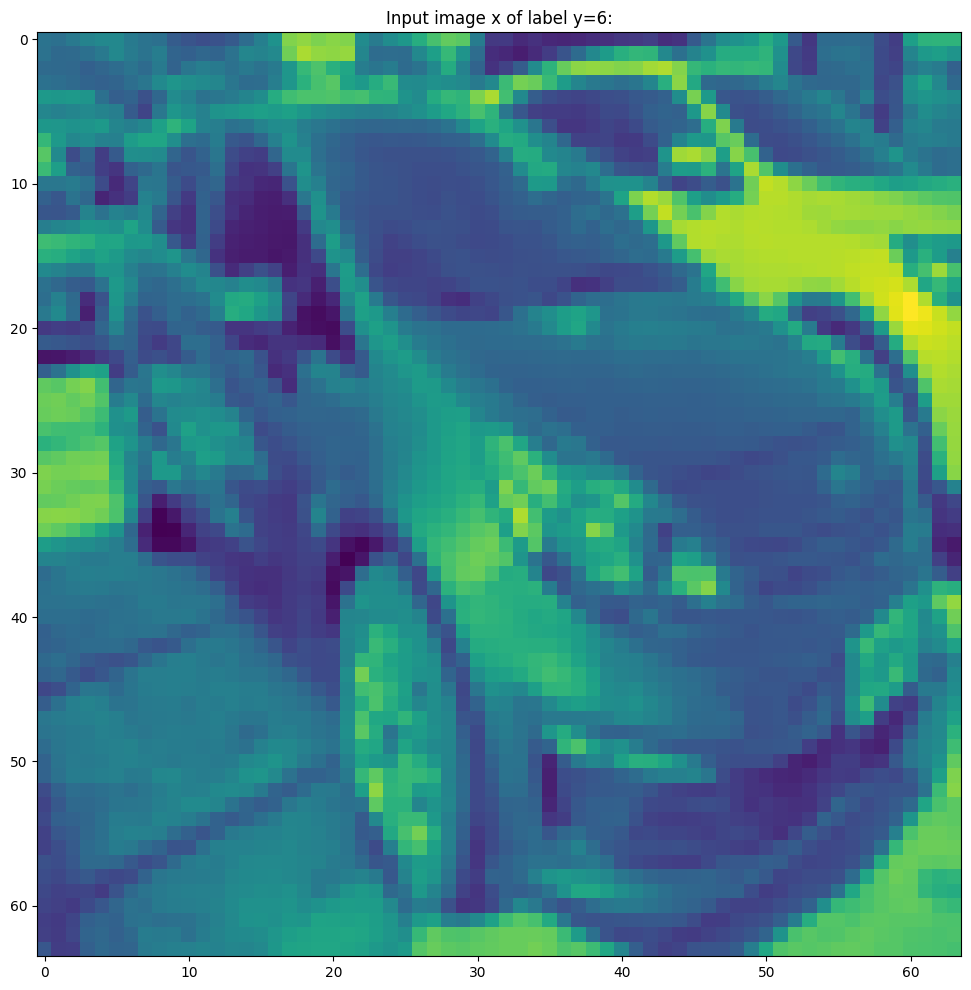

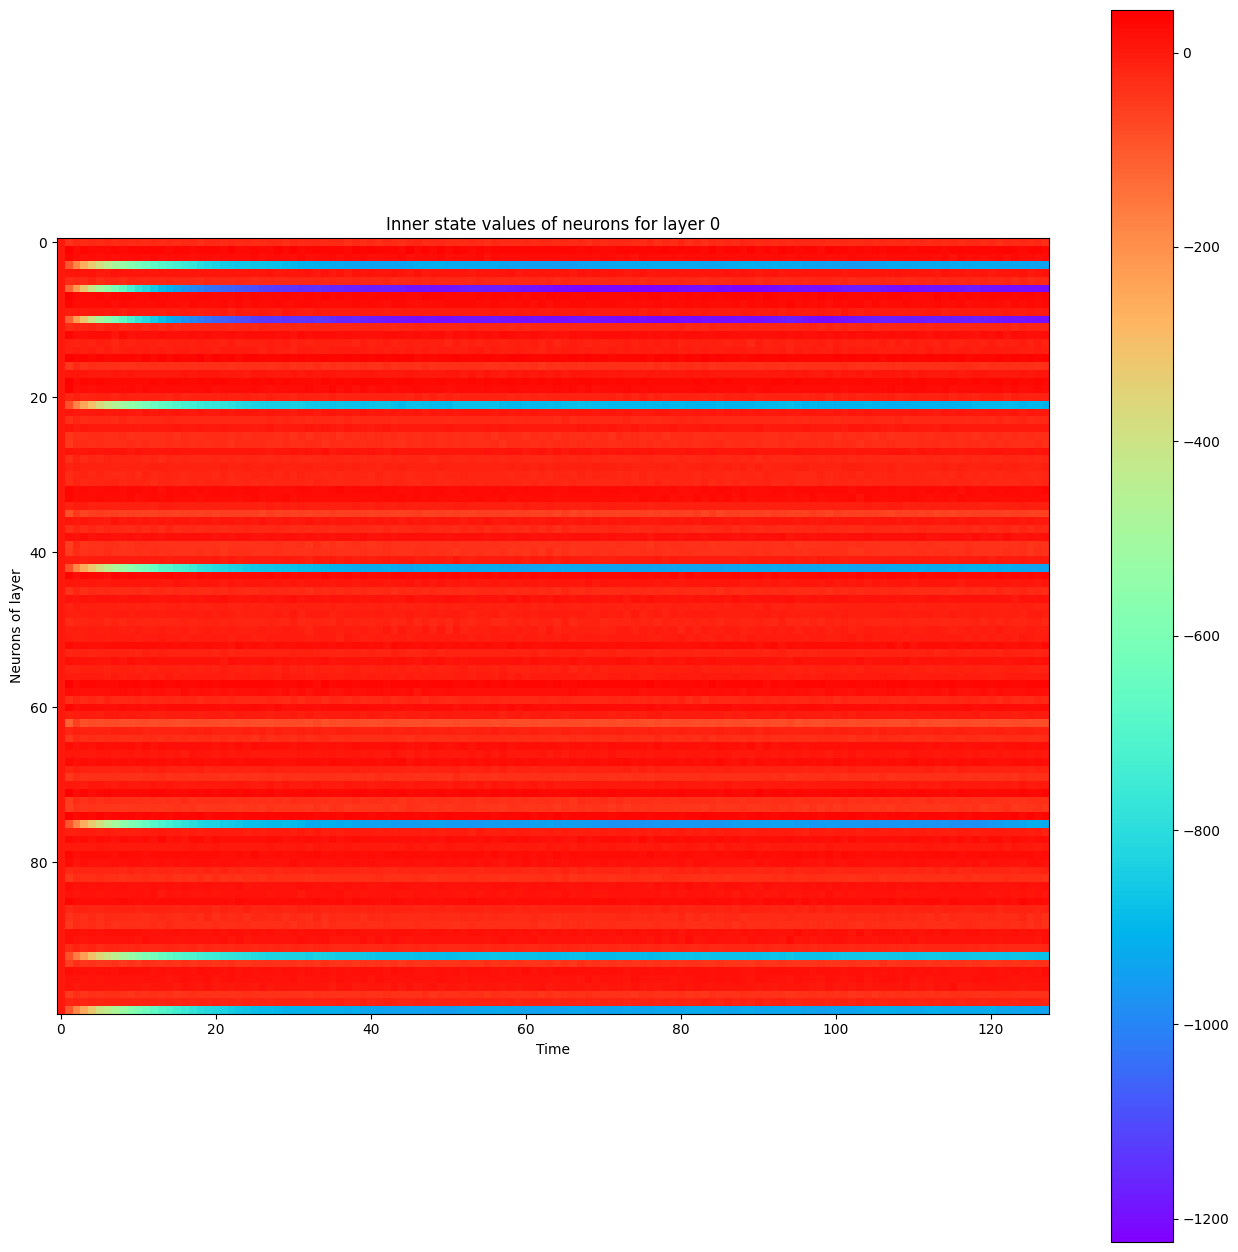

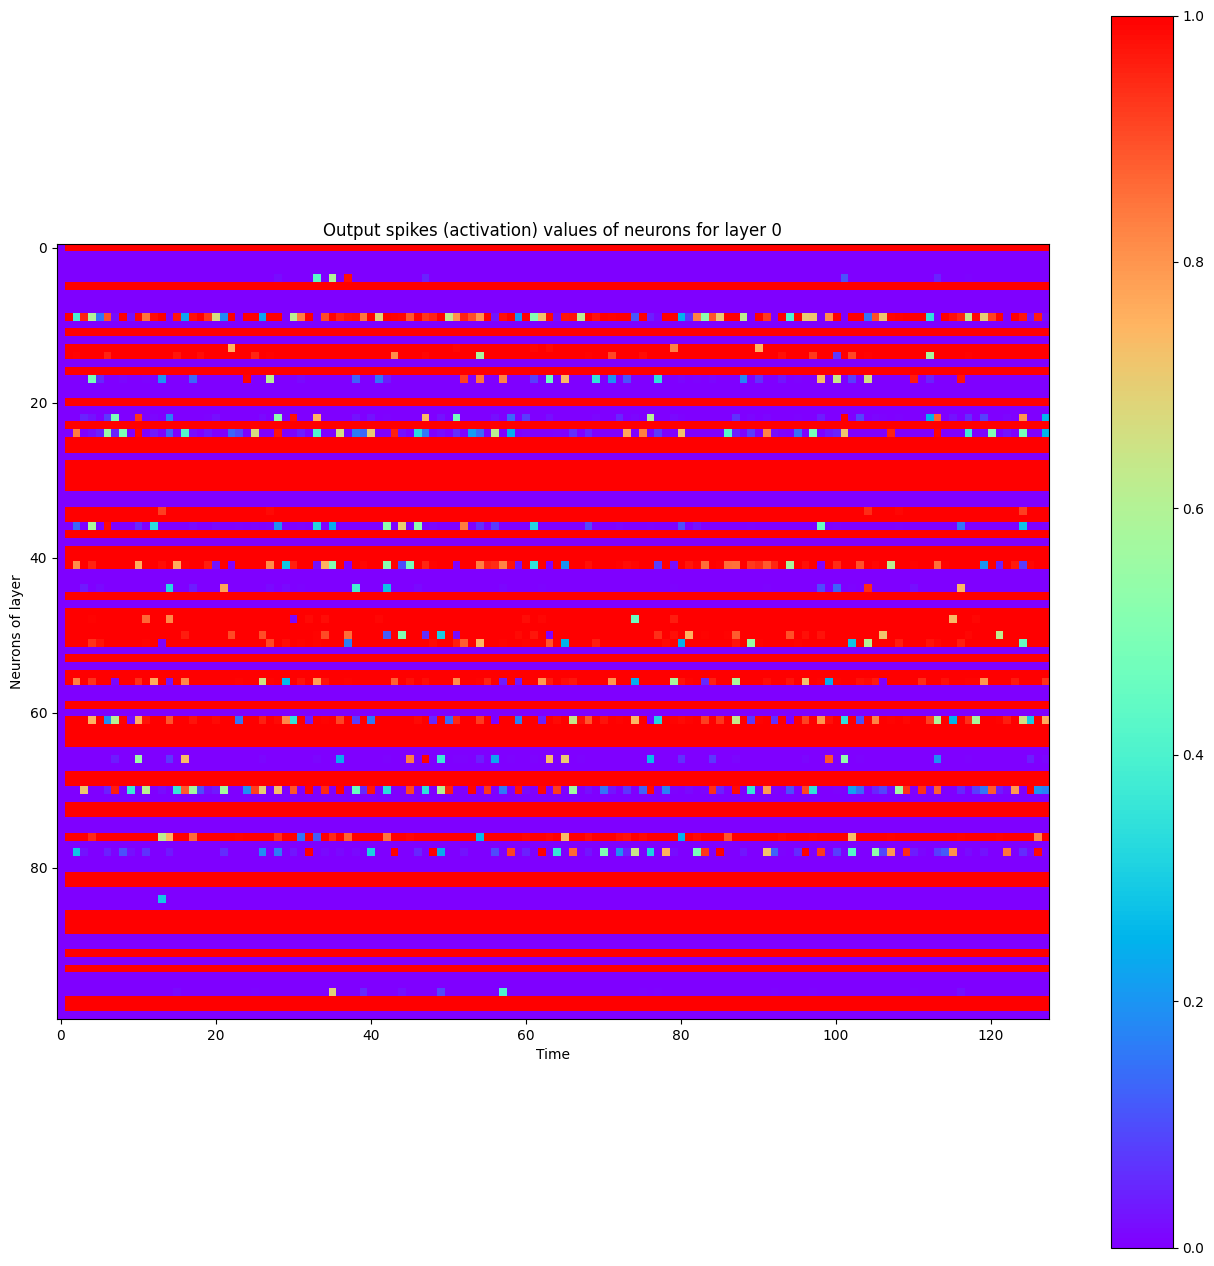

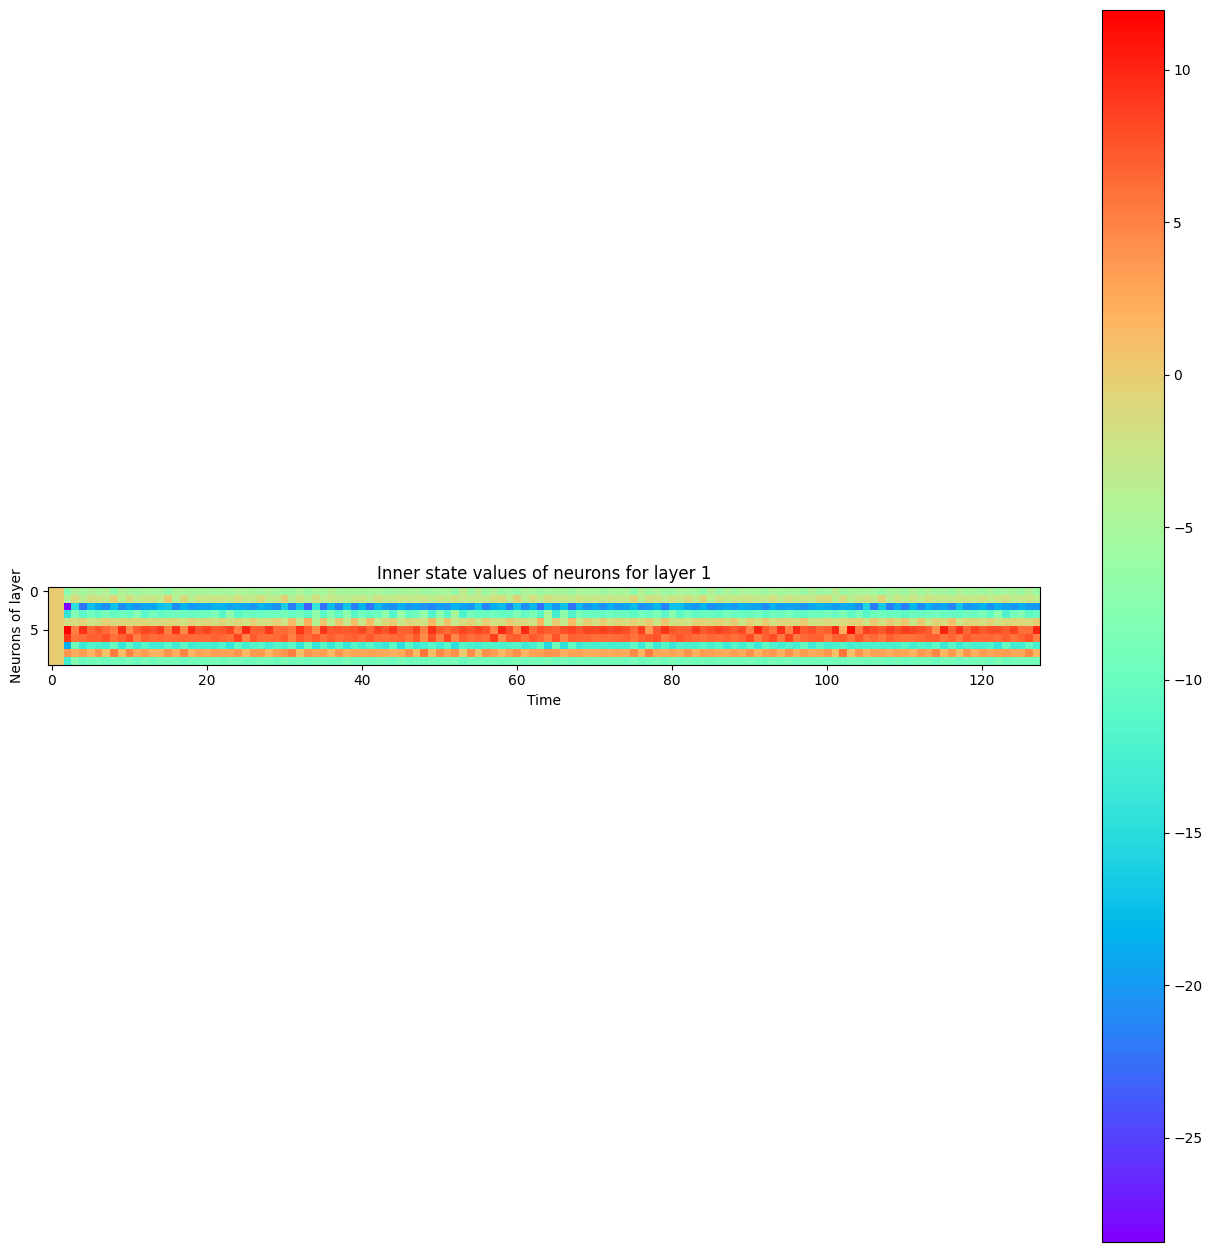

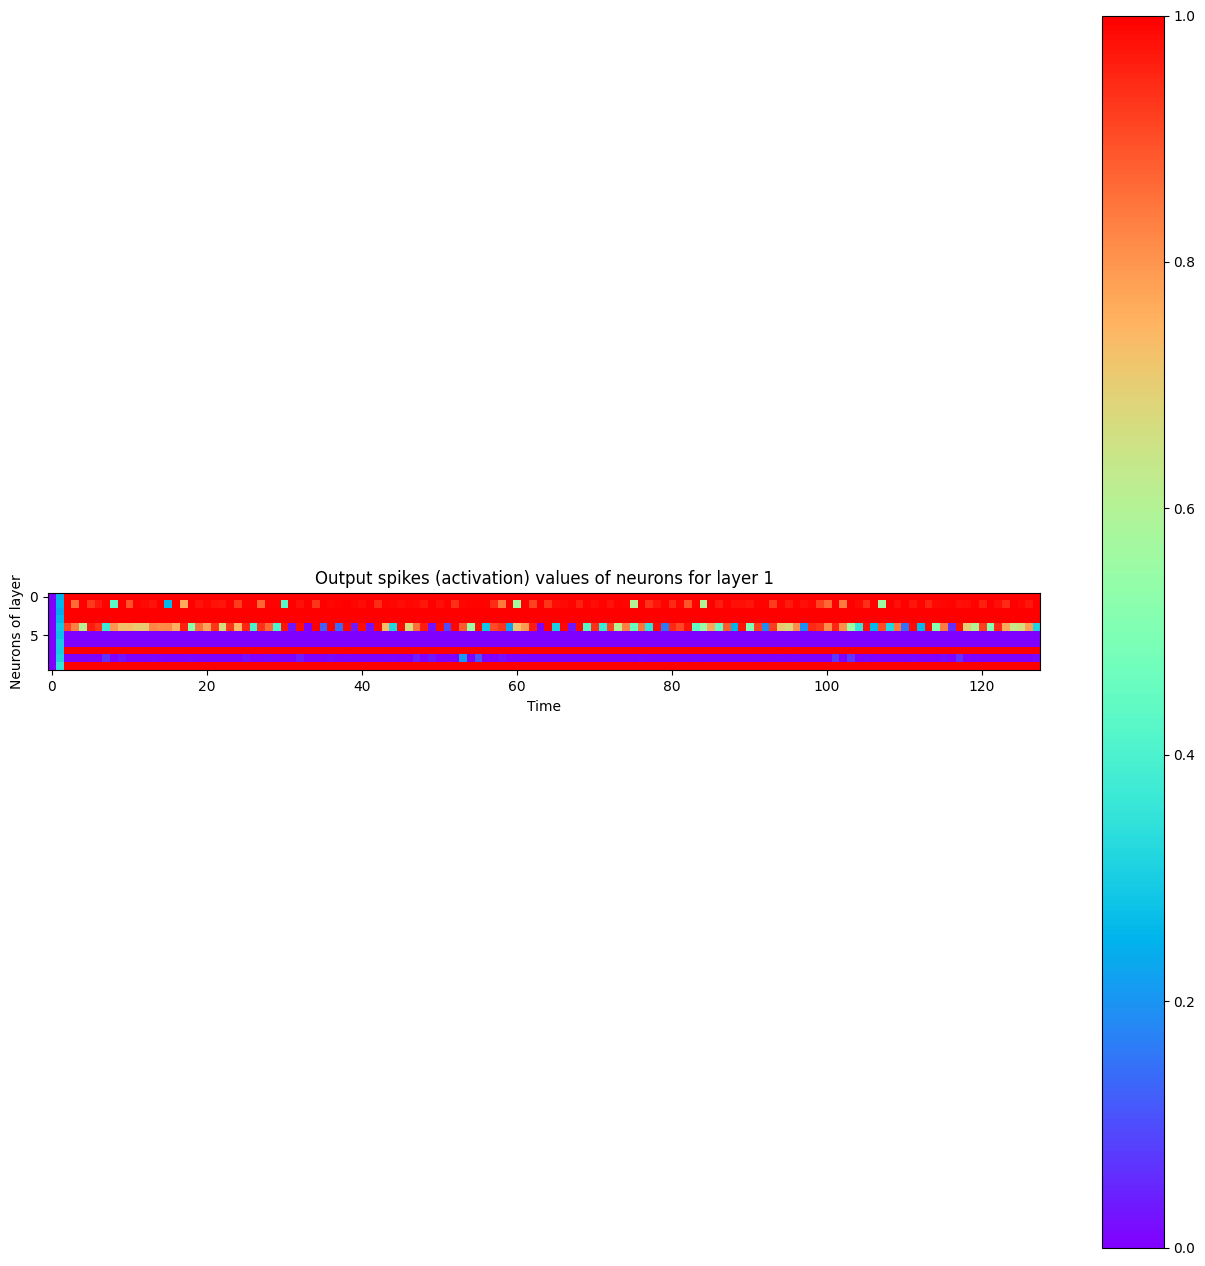

A hidden neuron that looks excited:


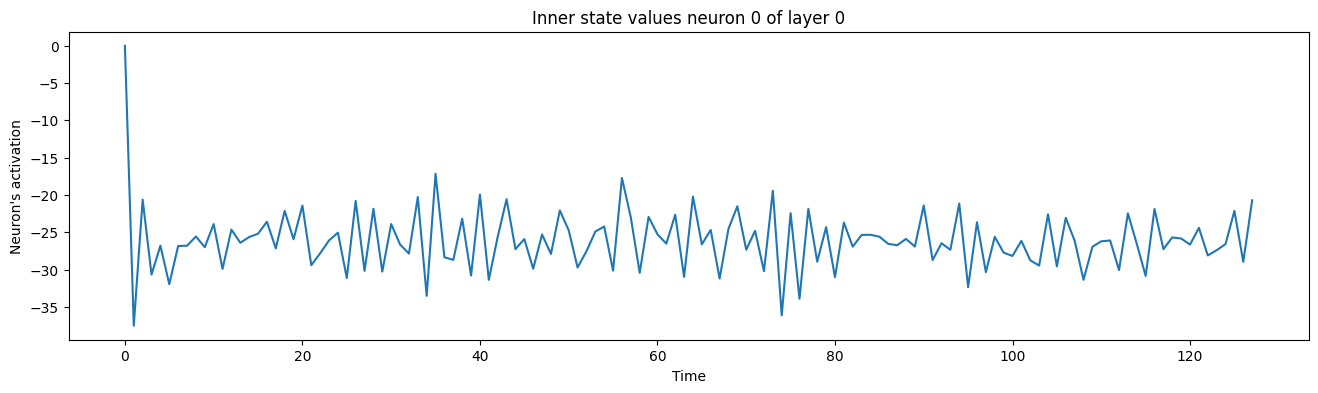

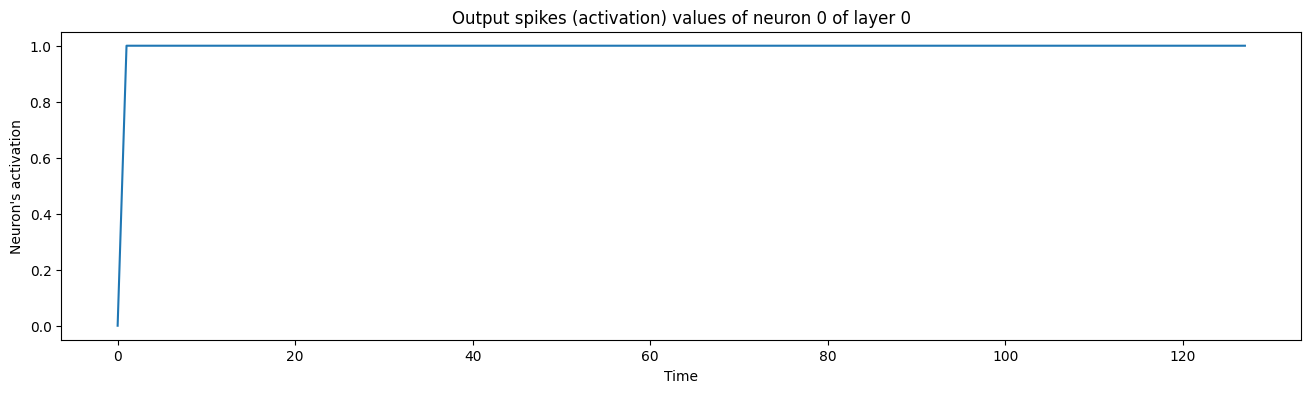

The output neuron of the label:


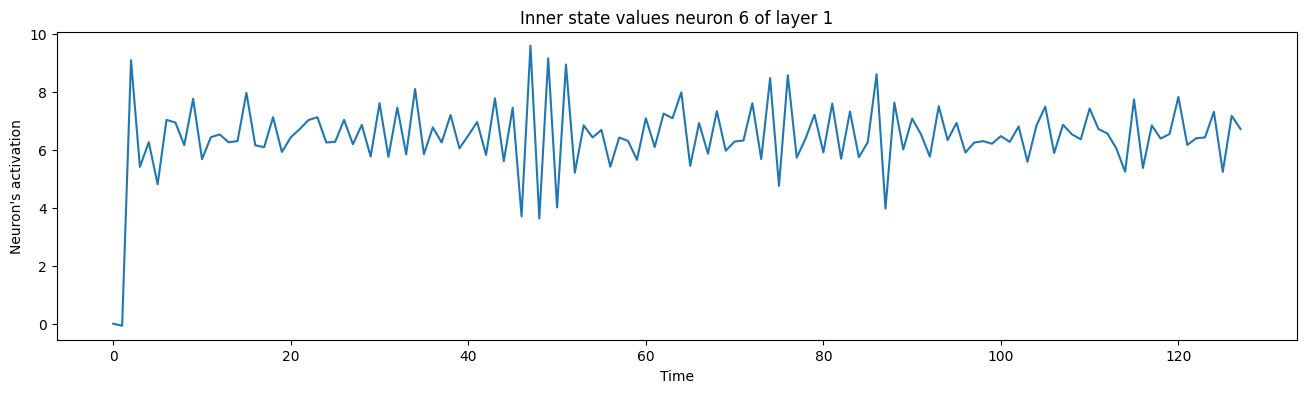

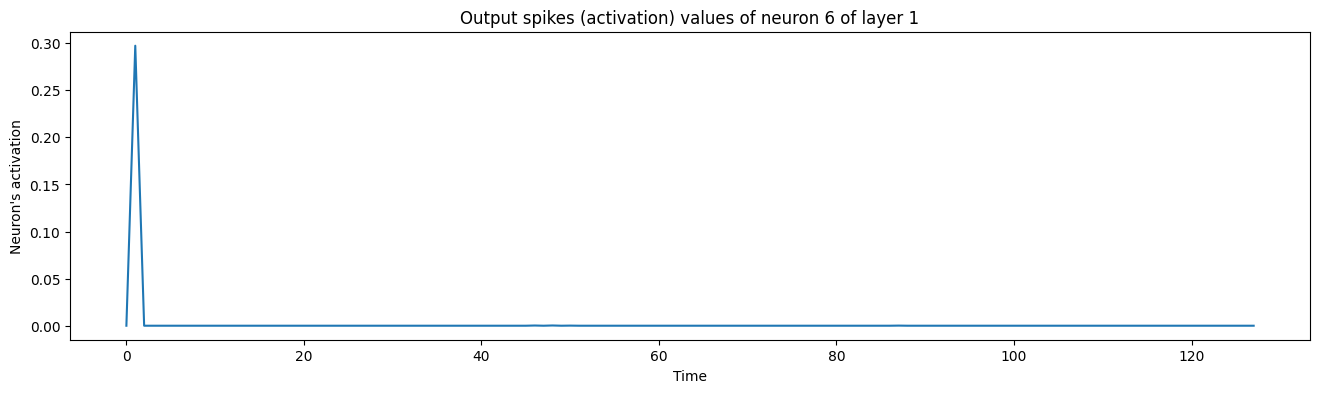

In [11]:
data, target = test_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]]) 
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)

#### 데이터셋 수정후 다시 돌림

In [18]:
spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0, input_size=3*64*64)
train_many_epochs(spiking_model, 100)

Train Epoch: 1 [0/2188 (0%)] Loss: 2.304430 Accuracy: 9.38%
Train Epoch: 1 [320/2188 (14%)] Loss: 1.977797 Accuracy: 28.12%
Train Epoch: 1 [640/2188 (29%)] Loss: 1.660142 Accuracy: 46.88%
Train Epoch: 1 [960/2188 (43%)] Loss: 1.510151 Accuracy: 50.00%
Train Epoch: 1 [1280/2188 (58%)] Loss: 1.605544 Accuracy: 37.50%
Train Epoch: 1 [1600/2188 (72%)] Loss: 1.442586 Accuracy: 50.00%
Train Epoch: 1 [1920/2188 (87%)] Loss: 1.341541 Accuracy: 46.88%

Test set: Average loss: 0.0418, Accuracy: 1088/2188 (49.73%)

Train Epoch: 2 [0/2188 (0%)] Loss: 1.199518 Accuracy: 71.88%
Train Epoch: 2 [320/2188 (14%)] Loss: 1.222365 Accuracy: 46.88%
Train Epoch: 2 [640/2188 (29%)] Loss: 1.169250 Accuracy: 50.00%
Train Epoch: 2 [960/2188 (43%)] Loss: 1.400662 Accuracy: 46.88%
Train Epoch: 2 [1280/2188 (58%)] Loss: 1.212182 Accuracy: 43.75%
Train Epoch: 2 [1600/2188 (72%)] Loss: 1.190330 Accuracy: 59.38%
Train Epoch: 2 [1920/2188 (87%)] Loss: 1.234304 Accuracy: 65.62%

Test set: Average loss: 0.0363, Accuracy:

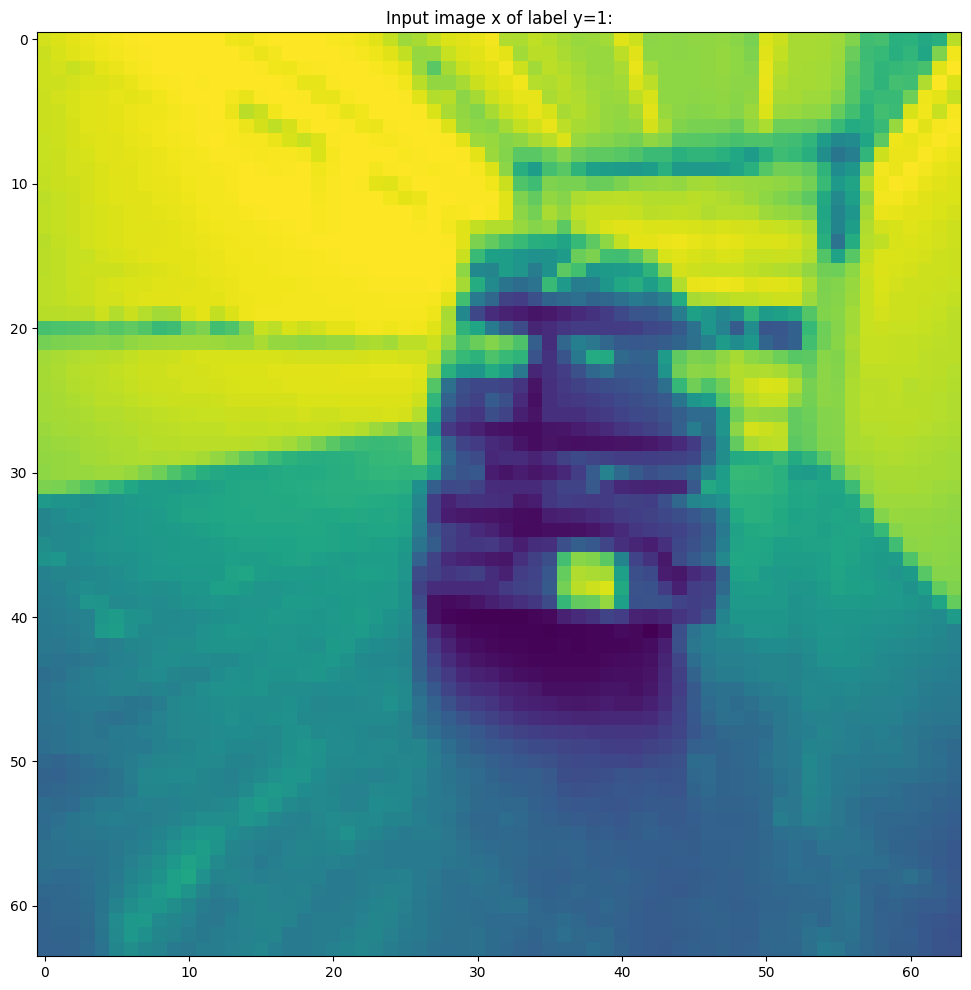

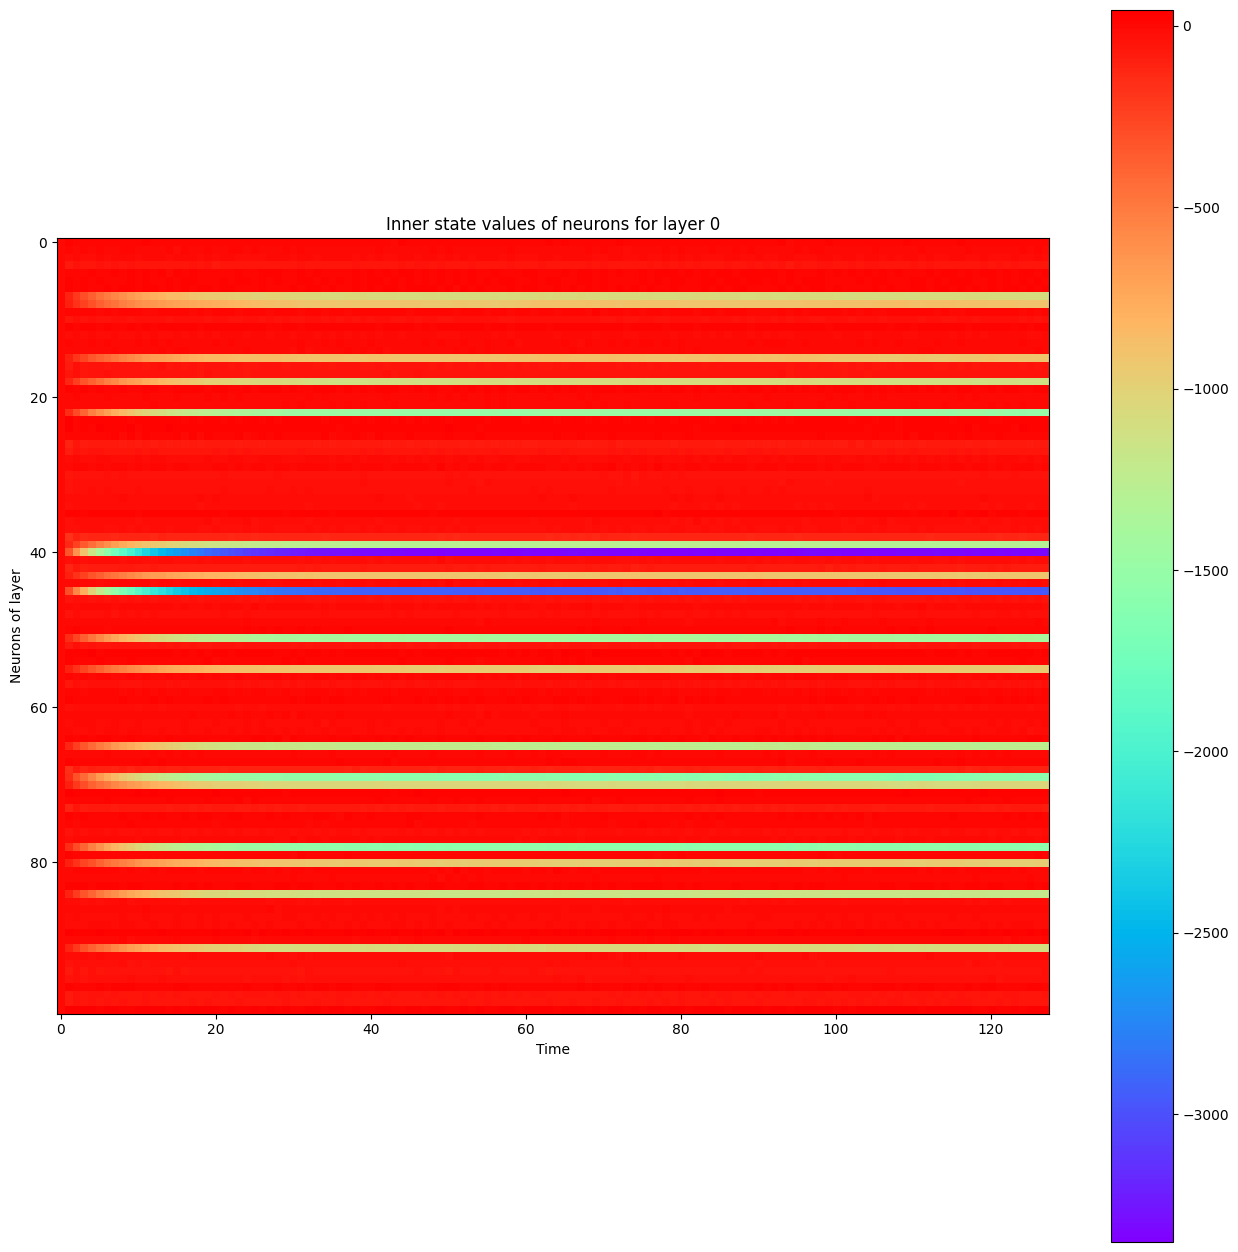

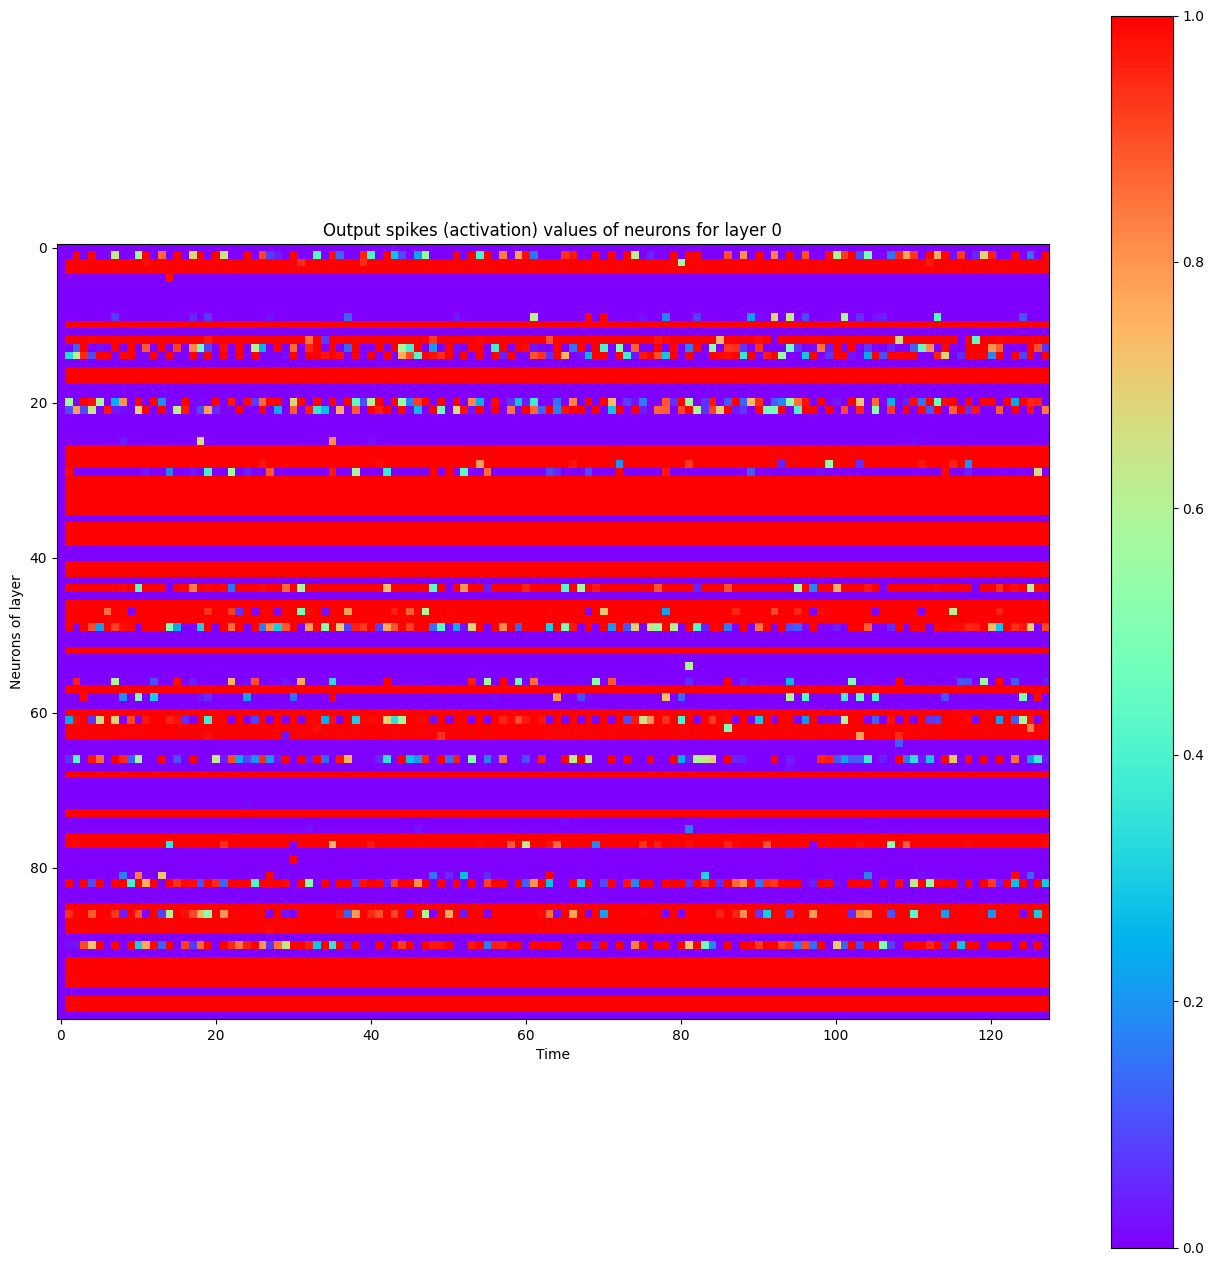

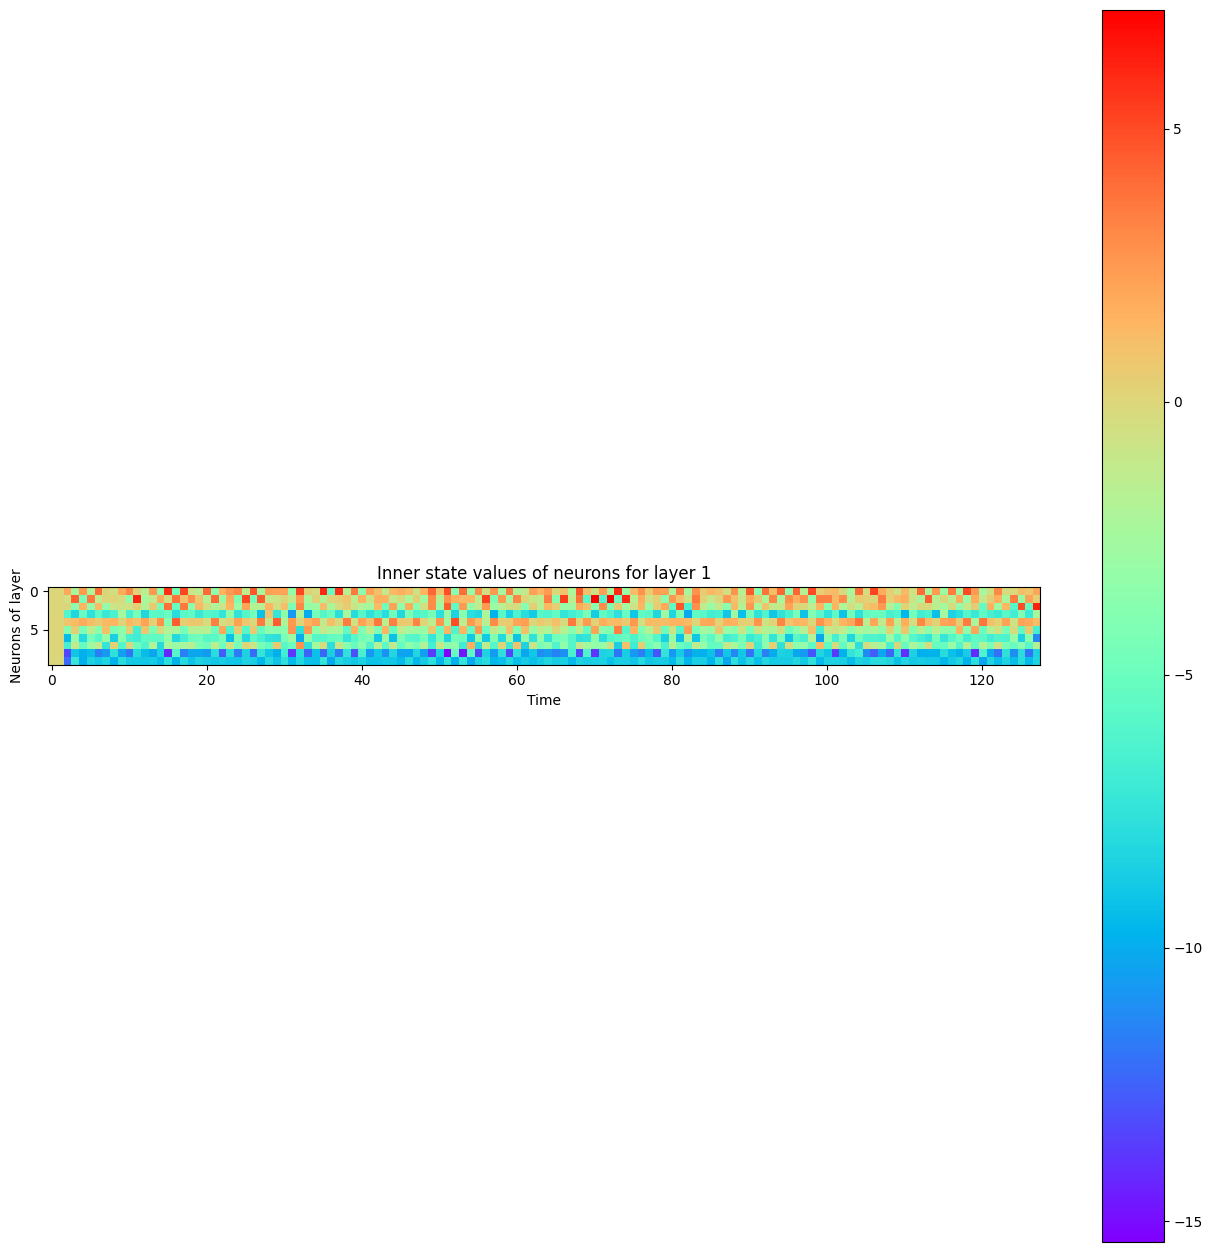

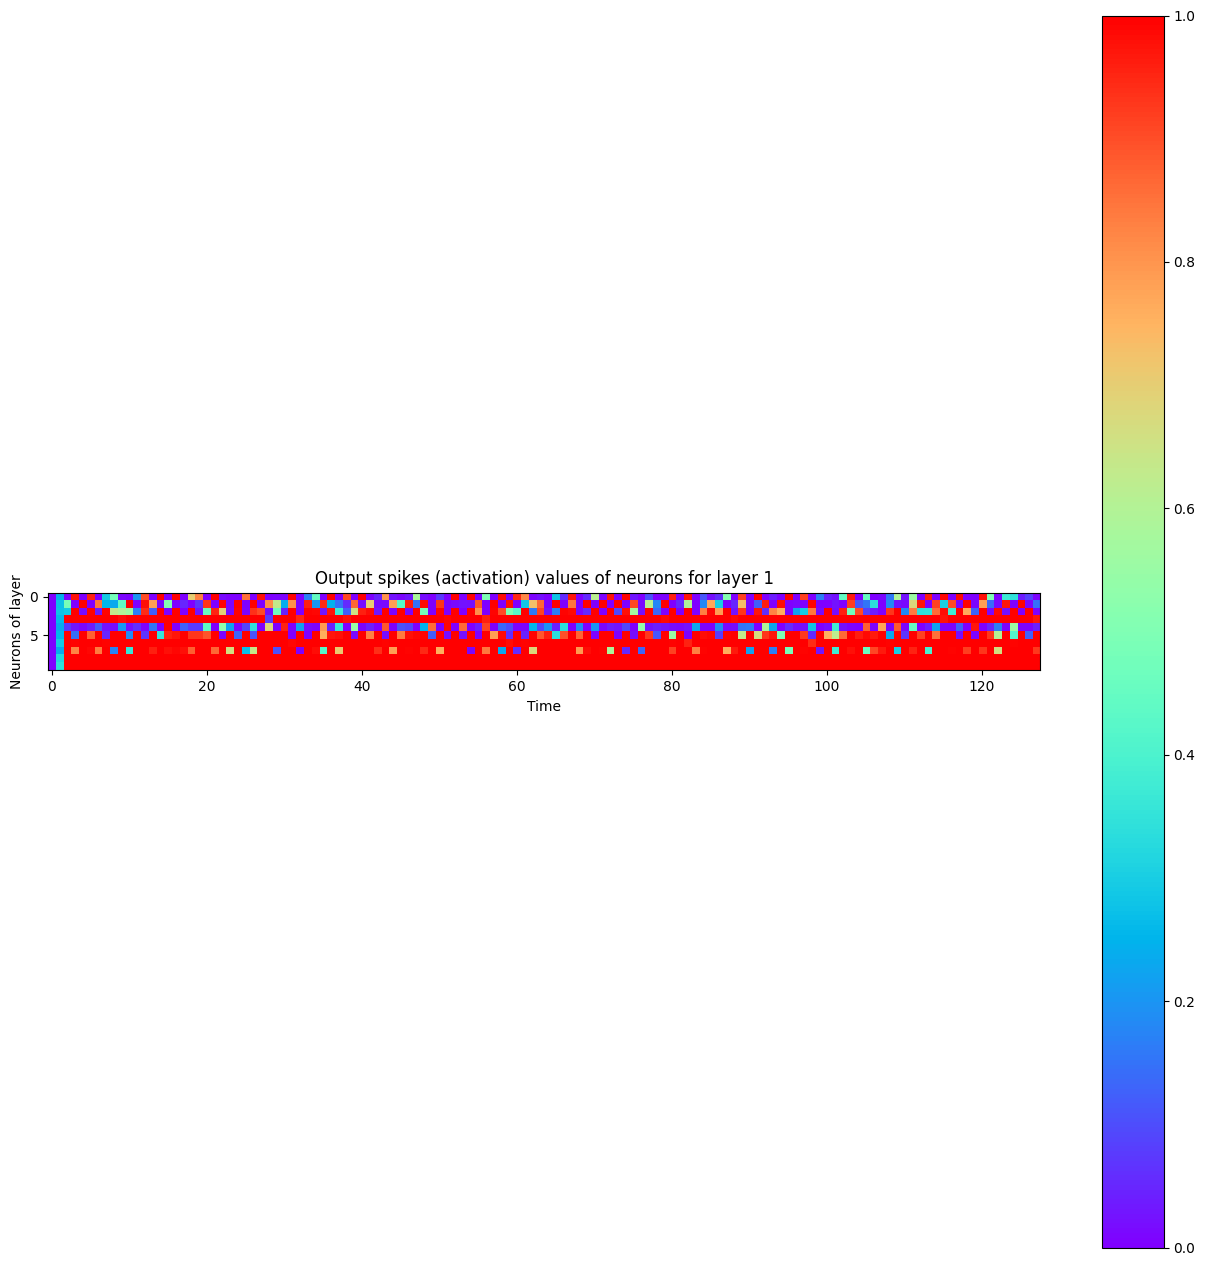

A hidden neuron that looks excited:


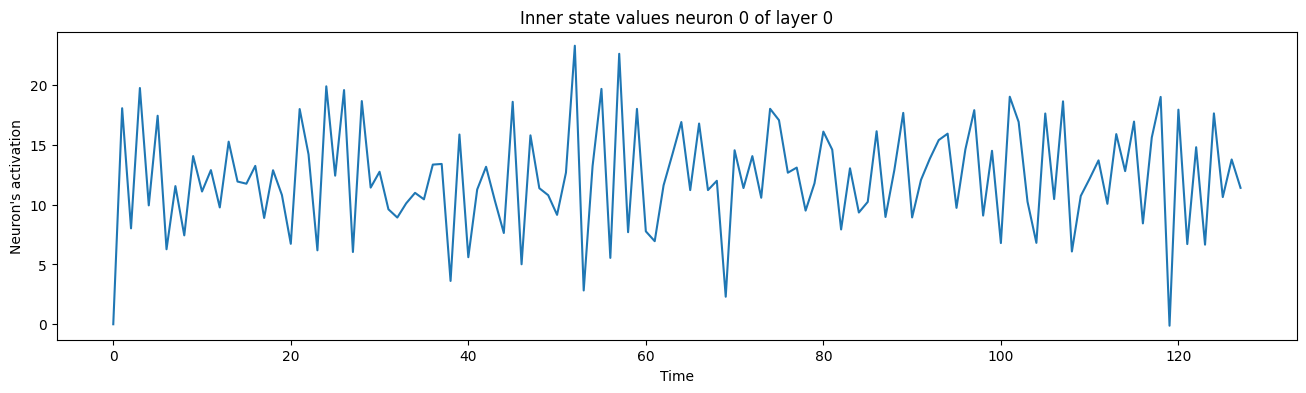

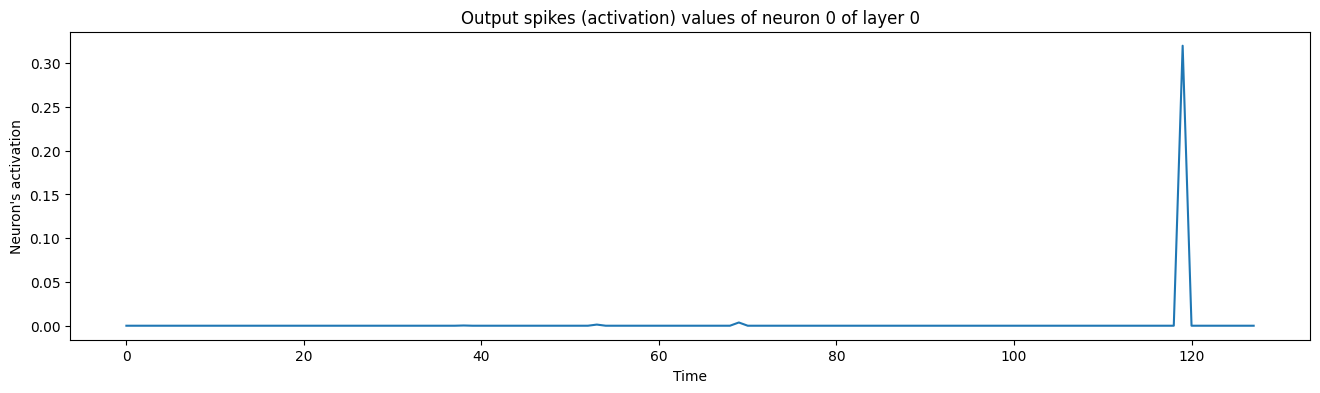

The output neuron of the label:


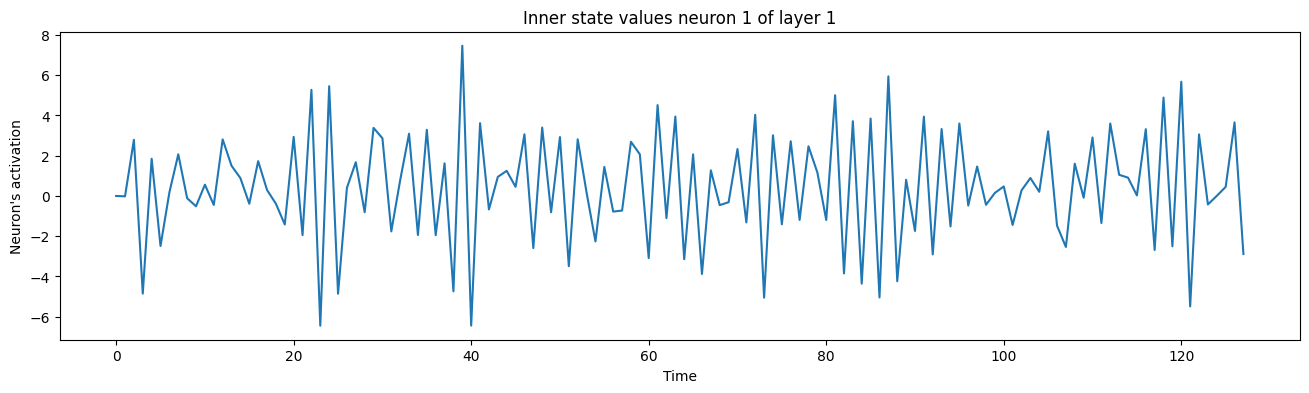

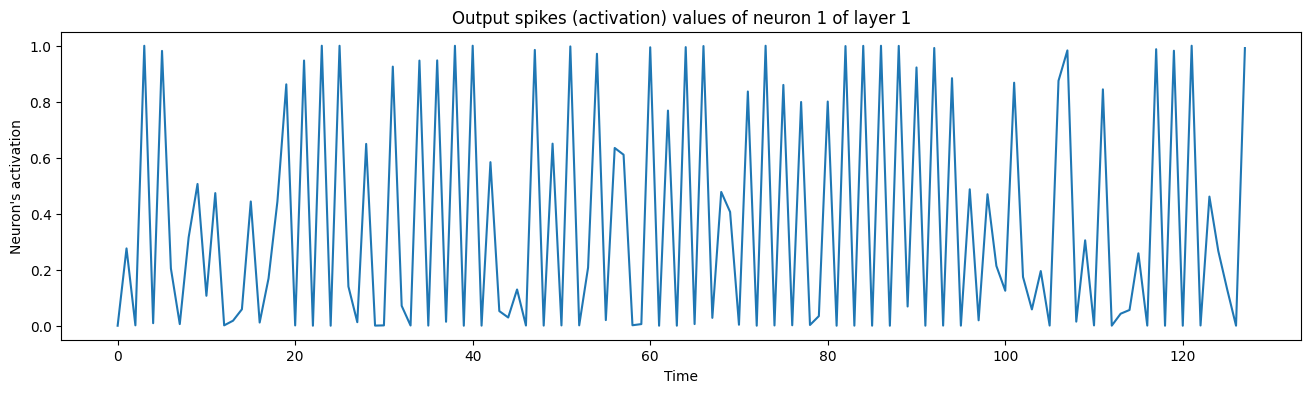

In [19]:
data, target = test_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]]) 
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)